CODE BLOCK: 1

In [19]:
# Install all required packages
# For GPU (CUDA 12.4) - Recommended for your RTX 4050
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

# Additional packages
!pip install tqdm
!pip install matplotlib
!pip install numpy
!pip install torchsummary

# Quick installation check
import sys
print("Python version:", sys.version)
print("\nChecking package installations...")

packages_to_check = {
    'torch': 'PyTorch',
    'torchvision': 'TorchVision',
    'tqdm': 'tqdm (progress bars)',
    'matplotlib': 'Matplotlib (plotting)',
    'numpy': 'NumPy',
}

missing_packages = []
for package, name in packages_to_check.items():
    try:
        __import__(package)
        print(f"✅ {name}: Installed")
    except ImportError:
        print(f"❌ {name}: Not installed")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠️ Missing packages detected: {', '.join(missing_packages)}")
    print("Installation in progress above. Please wait for completion.")
else:
    print("\n✅ All required packages are installed. Ready to proceed!")
    
# Verify CUDA availability after PyTorch installation
try:
    import torch
    print(f"\n🖥️ PyTorch Version: {torch.__version__}")
    print(f"🎮 CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"📊 GPU: {torch.cuda.get_device_name(0)}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
        print("✅ GPU acceleration is enabled!")
    else:
        print("⚠️ GPU not detected - will use CPU for training")
except ImportError:
    print("\n⚠️ PyTorch not yet installed. Please wait for installation to complete.")

Looking in indexes: https://download.pytorch.org/whl/cu124
Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]

Checking package installations...
✅ PyTorch: Installed
✅ TorchVision: Installed
✅ tqdm (progress bars): Installed
✅ Matplotlib (plotting): Installed
✅ NumPy: Installed

✅ All required packages are installed. Ready to proceed!

🖥️ PyTorch Version: 2.6.0+cu124
🎮 CUDA Available: True
📊 GPU: NVIDIA GeForce RTX 4050 Laptop GPU
💾 GPU Memory: 6.00 GB
✅ GPU acceleration is enabled!


# Lightweight CNN for MNIST Classification

This notebook implements a lightweight CNN for MNIST digit classification with the following goals:
- **Parameter Count**: < 25,000 parameters
- **Accuracy Target**: ≥ 95% test accuracy in 1 epoch

## Installation

Run the cell below to install all required packages:

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [21]:
# CUDA and Device Configuration
import platform
import datetime

print("="*60)
print("SYSTEM INFORMATION")
print("="*60)
cuda = torch.cuda.is_available()
print(f"CUDA Available: {cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

if cuda:
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

SYSTEM INFORMATION
CUDA Available: True
Device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
GPU Memory: 6.00 GB


CODE BLOCK: 3

In [22]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [23]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [24]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

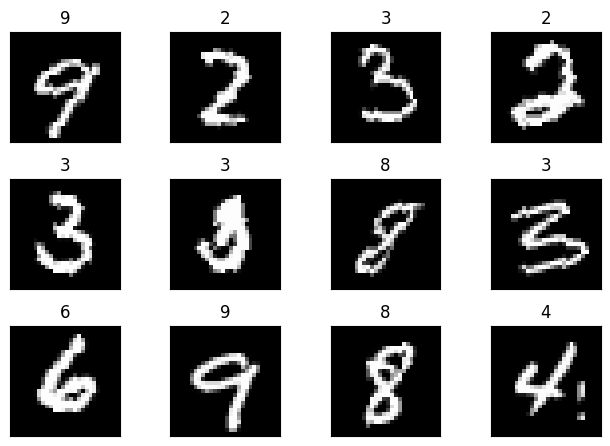

In [25]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [26]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3) # Output: 10x26x26
        self.bn1 = nn.BatchNorm2d(10)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3) # Output: 20x24x24
        self.bn2 = nn.BatchNorm2d(20)

        # Max Pooling and Dropout
        self.pool = nn.MaxPool2d(2, 2) # After first pool: 20x12x12, After second pool: 20x6x6
        self.dropout = nn.Dropout2d(0.25)

        # Fully Connected Layer
        self.fc1 = nn.Linear(20 * 6 * 6, 10) # 720 input features, 10 output classes

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(x)  # Add second pooling here
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 20 * 6 * 6)

        x = self.fc1(x)
        return F.log_softmax(x, dim=-1)

CODE BLOCK: 8

In [27]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [28]:
from tqdm import tqdm
import time

def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    pbar = tqdm(train_loader)
    
    train_loss = 0
    correct = 0
    processed = 0
    batch_losses = []
    
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        # Predict
        pred = model(data)
        
        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()
        batch_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        correct += GetCorrectPredCount(pred, target)
        processed += len(data)
        
        # Enhanced progress bar with more metrics
        pbar.set_description(
            f'Epoch {epoch} | Loss={loss.item():0.4f} | '
            f'Batch {batch_idx}/{len(train_loader)} | '
            f'Acc={100*correct/processed:0.2f}%'
        )
    
    epoch_time = time.time() - start_time
    final_acc = 100*correct/processed
    avg_loss = train_loss/len(train_loader)
    
    # Store metrics
    train_acc.append(final_acc)
    train_losses.append(avg_loss)
    
    # Detailed epoch summary
    print(f"\n📊 TRAINING SUMMARY - Epoch {epoch}")
    print(f"   ├── Final Accuracy: {final_acc:.2f}%")
    print(f"   ├── Average Loss: {avg_loss:.4f}")
    print(f"   ├── Min/Max Batch Loss: {min(batch_losses):.4f} / {max(batch_losses):.4f}")
    print(f"   ├── Total Samples: {processed}")
    print(f"   └── Time Taken: {epoch_time:.2f} seconds")
    
    return final_acc, avg_loss

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Per-class accuracy
            c = pred.squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i] == label
                class_total[label] += 1
    
    test_time = time.time() - start_time
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    test_acc.append(accuracy)
    test_losses.append(test_loss)
    
    # Detailed test summary
    print(f"\n📈 TEST SUMMARY - Epoch {epoch}")
    print(f"   ├── Test Accuracy: {accuracy:.2f}% ({correct}/{len(test_loader.dataset)})")
    print(f"   ├── Average Loss: {test_loss:.4f}")
    print(f"   ├── Time Taken: {test_time:.2f} seconds")
    
    # Per-class accuracy
    print(f"   └── Per-Class Accuracy:")
    for i in range(10):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i]/class_total[i]
            print(f"       ├── Class {i}: {class_acc:.2f}%")
    
    return accuracy, test_loss

CODE BLOCK: 10

In [29]:
# Model initialization and parameter count validation
model = Net().to(device)

# Define project goals from README
PARAM_GOAL = 25000
ACCURACY_GOAL = 95.0
EPOCH_GOAL = 1

print("="*60)
print("🎯 PROJECT GOALS")
print("="*60)
print(f"✅ Parameter Count: < {PARAM_GOAL:,} parameters")
print(f"✅ Test Accuracy: >= {ACCURACY_GOAL}% in {EPOCH_GOAL} epoch")
print("="*60)

# Detailed parameter count analysis
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print("\n📐 MODEL ARCHITECTURE ANALYSIS")
print("="*60)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-trainable Parameters: {non_trainable_params:,}")

# Check if model meets parameter goal
if total_params < PARAM_GOAL:
    print(f"✅ PASS: Model has {PARAM_GOAL - total_params:,} fewer parameters than goal!")
else:
    print(f"❌ FAIL: Model exceeds parameter limit by {total_params - PARAM_GOAL:,} parameters")
    
# Layer-wise parameter breakdown
print("\n📋 LAYER-WISE PARAMETER BREAKDOWN:")
print("-"*40)
for name, param in model.named_parameters():
    print(f"{name:20} | Shape: {str(list(param.shape)):20} | Params: {param.numel():,}")
print("="*60)

# Training configuration
print("\n⚙️ TRAINING CONFIGURATION")
print("="*60)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
criterion = nn.CrossEntropyLoss()
num_epochs = 5
print(f"Optimizer: Adam (lr={0.01})")
print(f"Scheduler: StepLR (step_size=15, gamma=0.1)")
print(f"Loss Function: CrossEntropyLoss")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")
print("="*60)

# Initialize tracking for goals
goal_achieved = False
goal_epoch = -1

print("\n🚀 STARTING TRAINING")
print("="*60)

for epoch in range(1, num_epochs+1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{num_epochs}")
    print(f"{'='*60}")
    
    # Train
    train_acc_epoch, train_loss_epoch = train(model, device, train_loader, optimizer, criterion, epoch)
    
    # Test
    test_acc_epoch, test_loss_epoch = test(model, device, test_loader, criterion, epoch)
    
    # Check if goal is achieved
    if epoch == EPOCH_GOAL and test_acc_epoch >= ACCURACY_GOAL:
        goal_achieved = True
        goal_epoch = epoch
        print(f"\n🎉 SUCCESS! Goal achieved in epoch {epoch}!")
        print(f"   Test Accuracy: {test_acc_epoch:.2f}% >= {ACCURACY_GOAL}%")
    elif epoch == EPOCH_GOAL and test_acc_epoch < ACCURACY_GOAL:
        print(f"\n⚠️ Goal not achieved in epoch {epoch}")
        print(f"   Test Accuracy: {test_acc_epoch:.2f}% < {ACCURACY_GOAL}%")
        print(f"   Shortfall: {ACCURACY_GOAL - test_acc_epoch:.2f}%")
    
    # Learning rate scheduling
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n📉 Learning Rate: {current_lr:.6f}")

print("\n" + "="*60)
print("🏁 TRAINING COMPLETE")
print("="*60)

🎯 PROJECT GOALS
✅ Parameter Count: < 25,000 parameters
✅ Test Accuracy: >= 95.0% in 1 epoch

📐 MODEL ARCHITECTURE ANALYSIS
Total Parameters: 9,190
Trainable Parameters: 9,190
Non-trainable Parameters: 0
✅ PASS: Model has 15,810 fewer parameters than goal!

📋 LAYER-WISE PARAMETER BREAKDOWN:
----------------------------------------
conv1.weight         | Shape: [10, 1, 3, 3]        | Params: 90
conv1.bias           | Shape: [10]                 | Params: 10
bn1.weight           | Shape: [10]                 | Params: 10
bn1.bias             | Shape: [10]                 | Params: 10
conv2.weight         | Shape: [20, 10, 3, 3]       | Params: 1,800
conv2.bias           | Shape: [20]                 | Params: 20
bn2.weight           | Shape: [20]                 | Params: 20
bn2.bias             | Shape: [20]                 | Params: 20
fc1.weight           | Shape: [10, 720]            | Params: 7,200
fc1.bias             | Shape: [10]                 | Params: 10

⚙️ TRAINING CONFIGURA

Epoch 1 | Loss=0.1748 | Batch 468/469 | Acc=90.91%: 100%|██████████| 469/469 [00:07<00:00, 64.03it/s] 



📊 TRAINING SUMMARY - Epoch 1
   ├── Final Accuracy: 90.91%
   ├── Average Loss: 0.3268
   ├── Min/Max Batch Loss: 0.0442 / 7.7472
   ├── Total Samples: 60000
   └── Time Taken: 7.32 seconds

📈 TEST SUMMARY - Epoch 1
   ├── Test Accuracy: 97.87% (9787/10000)
   ├── Average Loss: 0.0005
   ├── Time Taken: 4.74 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 98.98%
       ├── Class 1: 99.03%
       ├── Class 2: 98.84%
       ├── Class 3: 98.61%
       ├── Class 4: 94.60%
       ├── Class 5: 98.99%
       ├── Class 6: 98.96%
       ├── Class 7: 95.53%
       ├── Class 8: 97.02%
       ├── Class 9: 98.12%

🎉 SUCCESS! Goal achieved in epoch 1!
   Test Accuracy: 97.87% >= 95.0%

📉 Learning Rate: 0.010000

EPOCH 2/5


Epoch 2 | Loss=0.1383 | Batch 468/469 | Acc=96.25%: 100%|██████████| 469/469 [00:07<00:00, 66.51it/s] 



📊 TRAINING SUMMARY - Epoch 2
   ├── Final Accuracy: 96.25%
   ├── Average Loss: 0.1229
   ├── Min/Max Batch Loss: 0.0181 / 0.3989
   ├── Total Samples: 60000
   └── Time Taken: 7.05 seconds

📈 TEST SUMMARY - Epoch 2
   ├── Test Accuracy: 98.27% (9827/10000)
   ├── Average Loss: 0.0004
   ├── Time Taken: 4.45 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.69%
       ├── Class 1: 99.65%
       ├── Class 2: 97.77%
       ├── Class 3: 99.31%
       ├── Class 4: 95.82%
       ├── Class 5: 97.31%
       ├── Class 6: 98.96%
       ├── Class 7: 97.86%
       ├── Class 8: 97.43%
       ├── Class 9: 98.61%

📉 Learning Rate: 0.010000

EPOCH 3/5


Epoch 3 | Loss=0.1147 | Batch 468/469 | Acc=96.75%: 100%|██████████| 469/469 [00:06<00:00, 70.90it/s] 



📊 TRAINING SUMMARY - Epoch 3
   ├── Final Accuracy: 96.75%
   ├── Average Loss: 0.1067
   ├── Min/Max Batch Loss: 0.0240 / 0.2990
   ├── Total Samples: 60000
   └── Time Taken: 6.62 seconds

📈 TEST SUMMARY - Epoch 3
   ├── Test Accuracy: 98.59% (9859/10000)
   ├── Average Loss: 0.0004
   ├── Time Taken: 4.48 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.80%
       ├── Class 1: 99.74%
       ├── Class 2: 98.64%
       ├── Class 3: 98.02%
       ├── Class 4: 99.59%
       ├── Class 5: 98.21%
       ├── Class 6: 97.39%
       ├── Class 7: 98.44%
       ├── Class 8: 98.67%
       ├── Class 9: 97.22%

📉 Learning Rate: 0.010000

EPOCH 4/5


Epoch 4 | Loss=0.1256 | Batch 468/469 | Acc=96.95%: 100%|██████████| 469/469 [00:06<00:00, 73.38it/s] 



📊 TRAINING SUMMARY - Epoch 4
   ├── Final Accuracy: 96.95%
   ├── Average Loss: 0.0990
   ├── Min/Max Batch Loss: 0.0140 / 0.3032
   ├── Total Samples: 60000
   └── Time Taken: 6.39 seconds

📈 TEST SUMMARY - Epoch 4
   ├── Test Accuracy: 98.15% (9815/10000)
   ├── Average Loss: 0.0005
   ├── Time Taken: 4.51 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.80%
       ├── Class 1: 98.24%
       ├── Class 2: 97.87%
       ├── Class 3: 98.91%
       ├── Class 4: 97.66%
       ├── Class 5: 96.08%
       ├── Class 6: 98.23%
       ├── Class 7: 97.47%
       ├── Class 8: 99.38%
       ├── Class 9: 97.72%

📉 Learning Rate: 0.010000

EPOCH 5/5


Epoch 5 | Loss=0.0678 | Batch 468/469 | Acc=97.08%: 100%|██████████| 469/469 [00:06<00:00, 70.22it/s] 



📊 TRAINING SUMMARY - Epoch 5
   ├── Final Accuracy: 97.08%
   ├── Average Loss: 0.0933
   ├── Min/Max Batch Loss: 0.0092 / 0.3017
   ├── Total Samples: 60000
   └── Time Taken: 6.68 seconds

📈 TEST SUMMARY - Epoch 5
   ├── Test Accuracy: 98.90% (9890/10000)
   ├── Average Loss: 0.0003
   ├── Time Taken: 4.68 seconds
   └── Per-Class Accuracy:
       ├── Class 0: 99.49%
       ├── Class 1: 99.74%
       ├── Class 2: 99.13%
       ├── Class 3: 98.61%
       ├── Class 4: 99.29%
       ├── Class 5: 99.10%
       ├── Class 6: 98.75%
       ├── Class 7: 98.25%
       ├── Class 8: 98.15%
       ├── Class 9: 98.41%

📉 Learning Rate: 0.010000

🏁 TRAINING COMPLETE


CODE BLOCK: 11

In [30]:
# Final Results Summary
print("="*60)
print("📊 FINAL RESULTS SUMMARY")
print("="*60)

# Goal Achievement Status
print("\n🎯 GOAL ACHIEVEMENT STATUS:")
print("-"*40)
print(f"Parameter Goal (<{PARAM_GOAL:,}): {'✅ PASSED' if total_params < PARAM_GOAL else '❌ FAILED'}")
print(f"  → Model Parameters: {total_params:,}")
print(f"  → {'Under' if total_params < PARAM_GOAL else 'Over'} by: {abs(PARAM_GOAL - total_params):,}")

first_epoch_test_acc = test_acc[0] if len(test_acc) > 0 else 0
print(f"\nAccuracy Goal (≥{ACCURACY_GOAL}% in 1 epoch): {'✅ PASSED' if first_epoch_test_acc >= ACCURACY_GOAL else '❌ FAILED'}")
print(f"  → First Epoch Test Accuracy: {first_epoch_test_acc:.2f}%")
print(f"  → {'Exceeded' if first_epoch_test_acc >= ACCURACY_GOAL else 'Missed'} by: {abs(first_epoch_test_acc - ACCURACY_GOAL):.2f}%")

# Best Performance
if len(test_acc) > 0:
    best_test_acc = max(test_acc)
    best_epoch = test_acc.index(best_test_acc) + 1
    print(f"\n🏆 BEST PERFORMANCE:")
    print("-"*40)
    print(f"Best Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
    print(f"Best Train Accuracy: {max(train_acc):.2f}%")
    print(f"Lowest Test Loss: {min(test_losses):.4f}")
    print(f"Lowest Train Loss: {min(train_losses):.4f}")

# Overall Status
print("\n" + "="*60)
if total_params < PARAM_GOAL and first_epoch_test_acc >= ACCURACY_GOAL:
    print("🎉 OVERALL STATUS: ALL GOALS ACHIEVED! 🎉")
else:
    print("⚠️ OVERALL STATUS: GOALS NOT MET")
    print("\nRecommendations:")
    if total_params >= PARAM_GOAL:
        print("  • Reduce model complexity (fewer filters/layers)")
        print("  • Consider using depthwise separable convolutions")
    if first_epoch_test_acc < ACCURACY_GOAL:
        print("  • Increase learning rate for faster convergence")
        print("  • Adjust data augmentation strategies")
        print("  • Consider different optimizer (SGD with momentum)")
print("="*60)

📊 FINAL RESULTS SUMMARY

🎯 GOAL ACHIEVEMENT STATUS:
----------------------------------------
Parameter Goal (<25,000): ✅ PASSED
  → Model Parameters: 9,190
  → Under by: 15,810

Accuracy Goal (≥95.0% in 1 epoch): ✅ PASSED
  → First Epoch Test Accuracy: 97.87%
  → Exceeded by: 2.87%

🏆 BEST PERFORMANCE:
----------------------------------------
Best Test Accuracy: 98.90% (Epoch 5)
Best Train Accuracy: 97.08%
Lowest Test Loss: 0.0003
Lowest Train Loss: 0.0933

🎉 OVERALL STATUS: ALL GOALS ACHIEVED! 🎉


Text(0.5, 1.0, 'Test Accuracy')

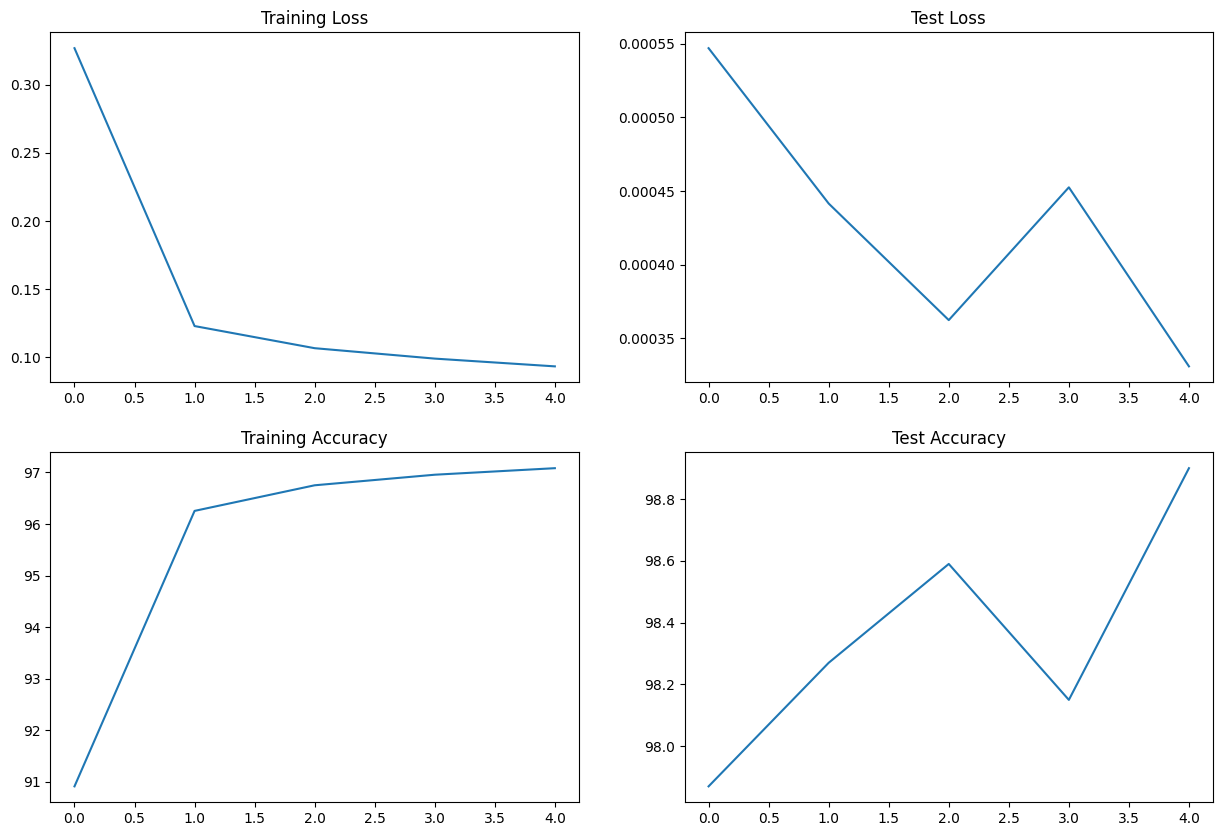

In [31]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [32]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
            Conv2d-3           [-1, 20, 24, 24]           1,820
       BatchNorm2d-4           [-1, 20, 24, 24]              40
         MaxPool2d-5           [-1, 20, 12, 12]               0
         MaxPool2d-6             [-1, 20, 6, 6]               0
         Dropout2d-7             [-1, 20, 6, 6]               0
            Linear-8                   [-1, 10]           7,210
Total params: 9,190
Trainable params: 9,190
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.31
Params size (MB): 0.04
Estimated Total Size (MB): 0.35
----------------------------------------------------------------
